In [1]:
import yfinance as yf
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from sklearn.preprocessing import MinMaxScaler, Normalizer
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport

In [1]:
data = yf.download(tickers='NQ=F', period="2y", interval='1h', auto_adjust= True, prepost = True)

NameError: name 'yf' is not defined

In [3]:
data.describe()

,Open,High,Low,Close,Volume
count,11613.000000,11613.000000,11613.000000,11613.000000,11613.000000
mean,13599.384582,13625.283152,13571.566296,13599.537798,23508.677430
std,1531.112004,1528.580267,1533.165741,1530.911839,33504.665211
min,10528.000000,10575.000000,10502.750000,10527.500000,0.000000
25%,12345.500000,12376.250000,12313.250000,12347.250000,3974.000000
50%,13598.750000,13622.500000,13572.750000,13598.250000,8328.000000
75%,14862.500000,14882.750000,14838.250000,14862.250000,34011.000000
max,16721.750000,16767.500000,16690.000000,16721.500000,785077.000000


<AxesSubplot:>

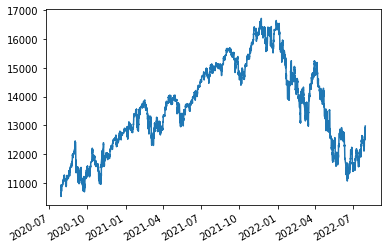

In [4]:
data.Close.plot()

In [5]:
#report = ProfileReport(data, title="Pandas Profiling Report", vars={"num": {"low_categorical_threshold": 0}})
#report.to_file('report.html')

In [6]:
data

,Open,High,Low,Close,Volume
2020-07-30 00:00:00-04:00,10674.25,10674.25,10656.50,10663.00,0
2020-07-30 01:00:00-04:00,10663.75,10665.75,10645.75,10658.00,3491
2020-07-30 02:00:00-04:00,10658.50,10665.50,10627.75,10629.00,5928
2020-07-30 03:00:00-04:00,10629.00,10635.00,10556.00,10564.75,17562
2020-07-30 04:00:00-04:00,10565.00,10575.00,10526.25,10530.25,9089
...,...,...,...,...,...
2022-07-29 12:00:00-04:00,12860.00,12902.25,12833.75,12896.00,45391
2022-07-29 13:00:00-04:00,12896.50,12938.50,12881.75,12925.50,36682
2022-07-29 14:00:00-04:00,12925.25,12971.50,12915.00,12959.00,44601
2022-07-29 15:00:00-04:00,12959.50,13012.00,12954.25,12974.75,79887


In [7]:
def split_dataset(ds, train_split=0.8, test_split=0.2):
    assert (train_split + test_split) == 1
    
    data_size = ds.Close.count()
    train_size = int(train_split * data_size)
    
    train_ds = data[:train_size]
    test_ds = data[train_size:]
    
    return train_ds, test_ds

In [8]:
def ts_data(data, x_steps, y_steps):
    #Split train and test data by date
    train_data, test_data =  split_dataset(data)
    #train_data = data[:'2021'].Close.values.reshape(-1,1)
    #test_data = data['2022':].Close.values.reshape(-1,1)
    train_data = train_data[['Close', 'Volume']]
    
    #Assemble Train data
    train_close = train_data.Close.values.reshape(-1,1)
    #train_volume = train_data.Volume.values.reshape(-1,1)
    
    #Assemble Test data
    test_close = test_data.Close.values.reshape(-1,1)
    #test_volume = test_data.Volume.values.reshape(-1,1)
    
    #Normolize train data
    sc = MinMaxScaler(feature_range=(0,1))
    train_data_scaled = sc.fit_transform(train_close)
    #train_volume_scaled = sc.fit_transform(train_volume)
    #train_data_scaled = np.concatenate((train_close_scaled,train_volume_scaled), axis=1)
    
    #We need to seprate x and y in train data, like a moving
    x_train = []
    y_train = []
    
    for i in range(x_steps, len(train_data_scaled) - 1):
        x_train.append(train_data_scaled[i-x_steps:i,:])
        y_train.append(train_data_scaled[i:i+y_steps,:])
        
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

    #assemble test data
    x = data.Close.values
    x = x[len(x) - len(test_data) - x_steps:] 
    x = x.reshape(-1,1)
    x = sc.transform(x)
    
    x_test = []
    y_test = []
    
    for i in range(x_steps, len(test_data) + x_steps - y_steps):
        x_test.append(x[i-x_steps:i,0])
        y_test.append(x[i:i+y_steps,0])
        
    x_test = np.array(x_test)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    y_test = np.array(y_test)
    
    return x_train, y_train, x_test, y_test, sc

In [9]:
x_train, y_train, x_test, y_test, sc = ts_data(data,6,2)

In [10]:
x_train.shape

(9283, 6, 1)

### LSTM-Model

In [11]:
LSTM_model = Sequential([
                                LSTM(50, return_sequences=True),
                                LSTM(25, return_sequences=True),
                                LSTM(12),
                                Dense(2)
                                ])

In [12]:
LSTM_model.compile(optimizer = 'adam', loss = 'huber_loss')

In [13]:
LSTM_model.fit(x_train, y_train, epochs=100, validation_split=0.1)

Epoch 1/100
262/262 [==============================] - 5s 7ms/step - loss: 0.0111 - val_loss: 2.7302e-04
Epoch 2/100
262/262 [==============================] - 1s 4ms/step - loss: 1.1704e-04 - val_loss: 3.5136e-04
Epoch 3/100
262/262 [==============================] - 1s 4ms/step - loss: 1.0226e-04 - val_loss: 2.7821e-04
Epoch 4/100
262/262 [==============================] - 1s 4ms/step - loss: 8.9933e-05 - val_loss: 3.1630e-04
Epoch 5/100
262/262 [==============================] - 1s 4ms/step - loss: 8.5054e-05 - val_loss: 2.5566e-04
Epoch 6/100
262/262 [==============================] - 1s 4ms/step - loss: 7.8942e-05 - val_loss: 3.0786e-04
Epoch 7/100
262/262 [==============================] - 1s 4ms/step - loss: 7.7266e-05 - val_loss: 2.6271e-04
Epoch 8/100
262/262 [==============================] - 1s 4ms/step - loss: 8.1255e-05 - val_loss: 2.6019e-04
Epoch 9/100
262/262 [==============================] - 1s 4ms/step - loss: 7.6370e-05 - val_loss: 2.5118e-04
Epoch 10/100
262/262 [=

In [14]:
LSTM_pred = LSTM_model.predict(x_test)
LSTM_pred.shape

73/73 [==============================] - 1s 1ms/step


(2321, 2)

In [27]:
from cProfile import label


def prediction_plot(prediction):
    fig, ax = plt.subplots(figsize = (48,12))
    ax.plot(data['2022':].index[:len(y_test)], sc.inverse_transform(y_test[:, 0].reshape(-1,1)), label='Real')
    ax.plot(data['2022':].index[:len(y_test)], sc.inverse_transform(prediction[:, 0].reshape(-1,1)), label='Prediction')
    ax.legend()

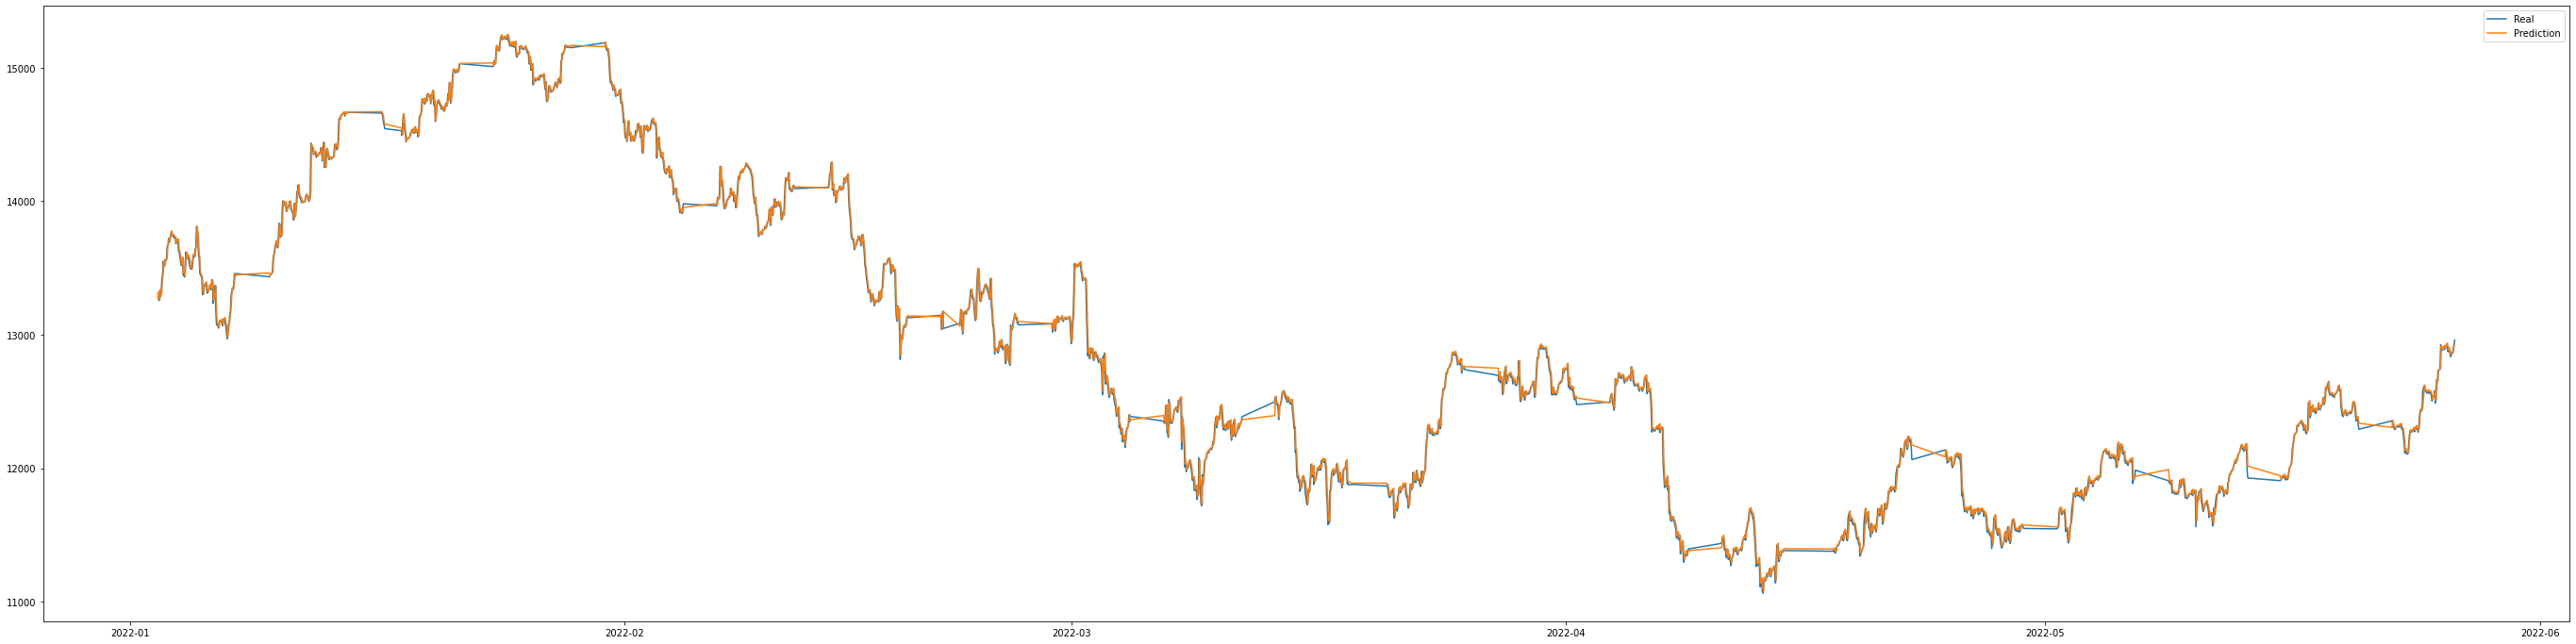

In [28]:
prediction_plot(LSTM_pred)